In [2]:
import matplotlib.pylab as plt
import numba

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import Estimation as st
import tables as tb
from Histogram import Histogram as hist
from PDF import PDF
from Utils import IsotopeDic, PartDic
from scipy.stats import poisson
import scipy.optimize as sop
import numpy as np
from scipy.special import gamma
from Fits import Fit

In [15]:
# %load ../Code/Fits.py
import Estimation as st
from Histogram import Histogram as hist
from PDF import PDF
from Utils import IsotopeDic, PartDic
from scipy.stats import poisson
import matplotlib.pylab as plt
import scipy.optimize as sop
import numpy as np
from scipy.special import gammaln
from copy import copy

def generalLogPoisson(x,mu):
    return -mu+x*np.log(mu+0.001)-gammaln(x+1)


class Fit():
    '''
    Class meant to perform the fit
    '''
    def __init__(self, E, spectrum, PDFs):
        '''
        E: x range (np array)
        spectrum: experimental points
        PDF: list of spectra PDFs
        nevs: normalizations for the spectra (they are the
            initial values for the fit)
        '''
        self.E = E[:]
        self.spectrum = spectrum.hist[:]
        self.PDFs = copy(PDFs)
        self.PDF_Val = np.array([np.array(pdfi.pdf(E)) for pdfi in self.PDFs])
        
    def LogLikelihood(self, nevs):
        '''
        function meant to compute the LogLikelihood
        '''
        nevs = nevs.reshape(len(nevs),1)
        ypdf = np.sum(nevs*self.PDF_Val,axis=0)
        ydat = self.spectrum
        lm = (np.array(generalLogPoisson(ydat,ypdf))).sum()
        return -lm

        
        
    def FitLLM(self,nevs,bounds=None, **kwargs):
        nevs = nevs.reshape(len(np.array(nevs)),1)
        fit = self.LogLikelihood
        if bounds==None:
            bounds = [[0,None] ] *(len(nevs))
        #res = sop.minimize(fit,nevs,method='L-BFGS-B',bounds = bounds,**kwargs)
        res = sop.minimize(fit,nevs,method='Nelder-Mead',**kwargs)
        ypdf = np.sum(nevs*self.PDF_Val,axis=0)
        ydat = self.spectrum
        chi2 = -1
        if (res.success):
            chi2 = np.sum((ypdf-ydat)**2/((ydat+0.0001)*(len(ypdf)-len(nevs))))
        res.chi2 = chi2
        return res
    
    def FitLLMScan(self,nevs, fixn, **kwargs):
        nevs = nevs.reshape(len(np.array(nevs)),1)
        fit = lambda(nevs)
        #res = sop.minimize(fit,nevs,method='L-BFGS-B',bounds = bounds,**kwargs)
        res = sop.minimize(fit,nevs,method='Nelder-Mead',**kwargs)
        if not(res.success):
            print('error')
        return res

    def GetSpectra(self,E,*nevs):
        ypdf = np.array([sum([n*pdfi.pdf(Ei) for pdfi,n in zip(self.PDFs,nevs)]) for Ei in self.E])
        #print ypdf
        return ypdf

    def FitLeastSQ(self,nevs,**kwargs):
        nevs = np.array(nevs)
        fit = self.GetSpectra
        res = sop.curve_fit(fit,self.E,self.spectrum, nevs)
        return res


In [16]:
f = tb.open_file("../Data/data_spectrum.h5", "r")

In [17]:
f

File(filename=../Data/data_spectrum.h5, title='', mode='r', root_uep='/', filters=Filters(complevel=0, shuffle=False, fletcher32=False, least_significant_digit=None))
/ (RootGroup) ''
/Bi (Array(125,)) ''
  atom := Float64Atom(shape=(), dflt=0.0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := None
/Co (Array(125,)) ''
  atom := Float64Atom(shape=(), dflt=0.0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := None
/E (Array(125,)) ''
  atom := Float64Atom(shape=(), dflt=0.0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := None
/K (Array(125,)) ''
  atom := Float64Atom(shape=(), dflt=0.0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := None
/Tl (Array(125,)) ''
  atom := Float64Atom(shape=(), dflt=0.0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := None
/bb2n (Array(125,)) ''
  atom := Float64Atom(shape=(), dflt=0.0)
  maindim := 0
  flavor := 'numpy'
  b

In [18]:
minE,maxE,nbin = 0.6,3.,125
E = f.root.E[:]
Co = f.root.Co[:]
K = f.root.K[:]
Tl = f.root.Tl[:]
Bi = f.root.Bi[:]
bb2n = f.root.bb2n[:]
testnn = f.root.testnn[:]
total = f.root.total[:]

In [19]:
h_Co = hist([],nbin,minE,maxE)
h_Co.hist = Co
h_Co.bins = E
h_K = hist([], nbin,minE,maxE)
h_K.hist = K
h_K.bins = E
h_Tl = hist([],nbin,minE,maxE)
h_Tl.hist = Tl
h_Tl.bins = E
h_Bi = hist([],nbin,minE,maxE)
h_Bi.hist = Bi
h_Bi.bins = E
h_bb2n = hist([],nbin,minE,maxE)
h_bb2n.hist = bb2n
h_bb2n.bins = E
h_testnn = hist(testnn,nbin,minE,maxE)
h_testnn.hist = testnn
h_testnn.bins = E
h_total = hist(total,nbin,minE,maxE)
h_total.hist = total
h_total.bins = E

In [20]:
interpol = 'cubic'
pdf_Co = PDF(h_Co,interpolation=interpol)
pdf_K = PDF(h_K,interpolation=interpol)
pdf_Tl = PDF(h_Tl,interpolation=interpol)
pdf_Bi = PDF(h_Bi,interpolation=interpol)
pdf_bb2n = PDF(h_bb2n,interpolation=interpol)
pdf_testnn = PDF(h_testnn,interpolation=interpol)
pdf_total = PDF(h_total,interpolation=interpol)

In [29]:
pdflis = [pdf_Co,pdf_K,pdf_Tl,pdf_Bi,pdf_bb2n]
nevslist = np.array([150000,80000,15000,40000,20000])/8.

In [30]:
fit = Fit(E,h_total,pdflis)

In [31]:
%time res_ll = fit.FitLLM(nevslist,tol=1e-10,options={"maxiter":100000,'ftol':1e-20})
#"gtol":1e-12, ,'maxls':50

CPU times: user 81.6 ms, sys: 89 µs, total: 81.7 ms
Wall time: 80.2 ms


In [32]:
res_ll

          chi2: 1.7545517115556524
 final_simplex: (array([[ 18395.02927031,  10041.54032921,   1992.53167288,   4839.01680656,
          1384.77826122],
       [ 18395.02927031,  10041.54032921,   1992.53167288,   4839.01680656,
          1384.77826122],
       [ 18395.02927031,  10041.54032921,   1992.53167288,   4839.01680656,
          1384.77826122],
       [ 18395.02927031,  10041.54032921,   1992.53167288,   4839.01680656,
          1384.77826122],
       [ 18395.02927031,  10041.54032921,   1992.53167288,   4839.01680656,
          1384.77826122],
       [ 18395.02927031,  10041.54032921,   1992.53167288,   4839.01680656,
          1384.77826122]]), array([ 357.46490713,  357.46490713,  357.46490713,  357.46490713,
        357.46490713,  357.46490713]))
           fun: 357.46490713126883
       message: 'Optimization terminated successfully.'
          nfev: 599
           nit: 299
        status: 0
       success: True
             x: array([ 18395.02927031,  10041.54032921,  

In [33]:
nevslist

array([ 18750.,  10000.,   1875.,   5000.,   2500.])

In [34]:
%time res_ls = fit.FitLeastSQ(nevslist,tol=1e-12,options={"maxiter":1000})

CPU times: user 1.34 s, sys: 82.7 ms, total: 1.42 s
Wall time: 1.42 s


In [35]:
for i in range(len(res_ls[0])):
    print(res_ls[0][i],' +- ', (res_ls[1][i,i])**0.5)

18967.8383795  +-  297.667231852
10149.6005837  +-  248.442467245
2634.76085786  +-  397.014502889
4478.6278918  +-  312.113365883
540.682346863  +-  478.157932923


# Errors

In [37]:
N = 100
nx = np.linspace(0,result[i]*2,N)
LL = []
chi = []
for ni in nx:
    res = fit.FitLLMScan(nevslist,ni,tol=1e-8,options={"maxiter":1000})
    LL.append(res.fun)
    chi.append(res.chi2)
    print(ni,'\n',res,'\n \n')

NameError: name 'result' is not defined

In [38]:
plt.plot(nx,LL)
#plt.plot(nx,chi)


NameError: name 'nx' is not defined

In [39]:
N = 50
for i in range(5):
    nevs = np.copy(result)
    x = np.linspace(0,result[i]*3,N)
    y = np.zeros([N,1])
    for event in range(len(x)):
        nevs[i] = x[event]
        y[event] = fit.LogLikelihood(nevs)
    plt.plot(x,y-357.46490713137422-2)
    plt.plot(result[i],fit.LogLikelihood(result)-357.46490713137422-2,'o')
plt.plot([0,60000],[0,0])

NameError: name 'result' is not defined

In [40]:
plt.plot(x,y-357.46490713137422-0.5)
plt.plot(result[i],fit.LogLikelihood(result)-357.46490713137422-0.5,'o')
plt.plot([x[0],x[-1]],[0,0])
plt.xlim(1225,1226)
plt.ylim(-0.005151,0.0051)
#for i in 

NameError: name 'x' is not defined

In [41]:
x = np.linspace(0,result[i]*3,1000)

NameError: name 'result' is not defined

In [42]:
res

NameError: name 'res' is not defined

In [43]:
357.46490713125877 - 362.333


-4.8680928687412575

In [44]:
1384.7787-1225

159.77870000000007

In [45]:
testnn.sum()

1376.0

In [46]:
bb2n.sum()

11421.0

In [47]:
(1376.0-1384.7787)/159.7787

-0.05494286785410116

In [48]:
1383.24

1383.24

# Plot

In [49]:
result = np.array([18395.02975447, 10041.5398816, 1992.53178756, 4839.01641257, 1384.7787113])

In [50]:
interpol = 'nearest'
pdf_CoP = PDF(h_Co,factor=result[0],interpolation=interpol)
pdf_KP = PDF(h_K,factor=result[1],interpolation=interpol)
pdf_TlP = PDF(h_Tl,factor=result[2],interpolation=interpol)
pdf_BiP = PDF(h_Bi,factor=result[3],interpolation=interpol)
pdf_bb2nP = PDF(h_bb2n,factor=result[4],interpolation=interpol)



In [51]:
Ep = np.linspace(0.6,2.8,1000)
aux =(E>0.6)&(E<2.8)
Ea = E[aux]
totala = total[aux]
testnna = testnn[aux]
y_CoP = pdf_CoP.pdf(Ep)
y_KP = pdf_KP.pdf(Ep)
y_TlP = pdf_TlP.pdf(Ep)
y_BiP = pdf_BiP.pdf(Ep)
y_bb2nP = pdf_bb2nP.pdf(Ep)
fittotal = y_CoP+y_KP+y_TlP+y_BiP+y_bb2nP
y_CoP[0]=0.00001
y_CoP[-1]=0.00001
y_KP[0]=0.00001
y_KP[-1]=0.00001
y_BiP[0]=0.00001
y_BiP[-1]=0.00001
y_TlP[0]=0.00001
y_TlP[-1]=0.00001


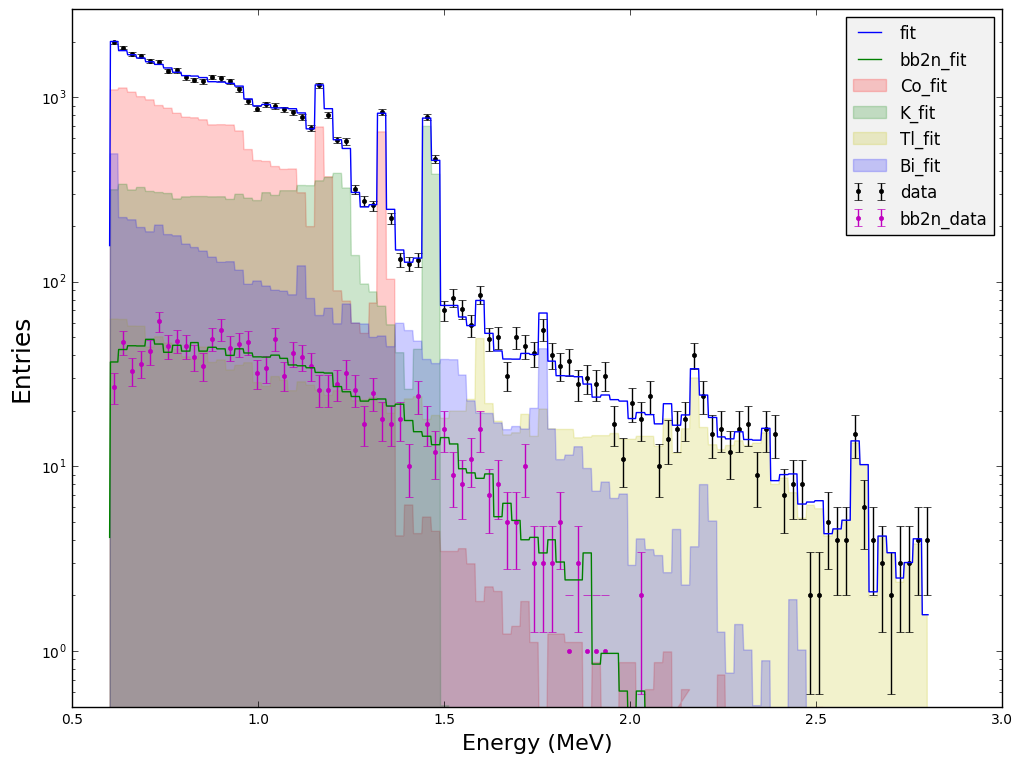

In [52]:
alfa= 0.2
plt.semilogy()
plt.ylim(0.5,3e3)
plt.errorbar(Ea,totala,yerr=np.sqrt(totala),marker='.',elinewidth=1,
             linewidth=0,label='data',color='black')
plt.errorbar(Ea,testnna,yerr=np.sqrt(testnna),marker='.',elinewidth=1,
             linewidth=0,label='bb2n_data',color='m')
plt.plot(Ep,fittotal,label='fit')
plt.plot(Ep,y_bb2nP,label='bb2n_fit')
plt.fill_between(Ep,0,y_CoP,label='Co_fit',alpha=alfa,color='r')
plt.fill_between(Ep,0,y_KP,label='K_fit',alpha=alfa,color='g')
plt.fill_between(Ep,0,y_TlP,label='Tl_fit',alpha=alfa,color='y')
plt.fill_between(Ep,0,y_BiP,label='Bi_fit',alpha=alfa,color='b')
#plt.plot(E)
plt.gcf().set_size_inches(12,9)
plt.legend().get_frame().set_facecolor('0.95')
plt.xlabel('Energy (MeV)',fontsize=16)
plt.ylabel('Entries',fontsize=18)
plt.savefig('fitspectrum.pdf')

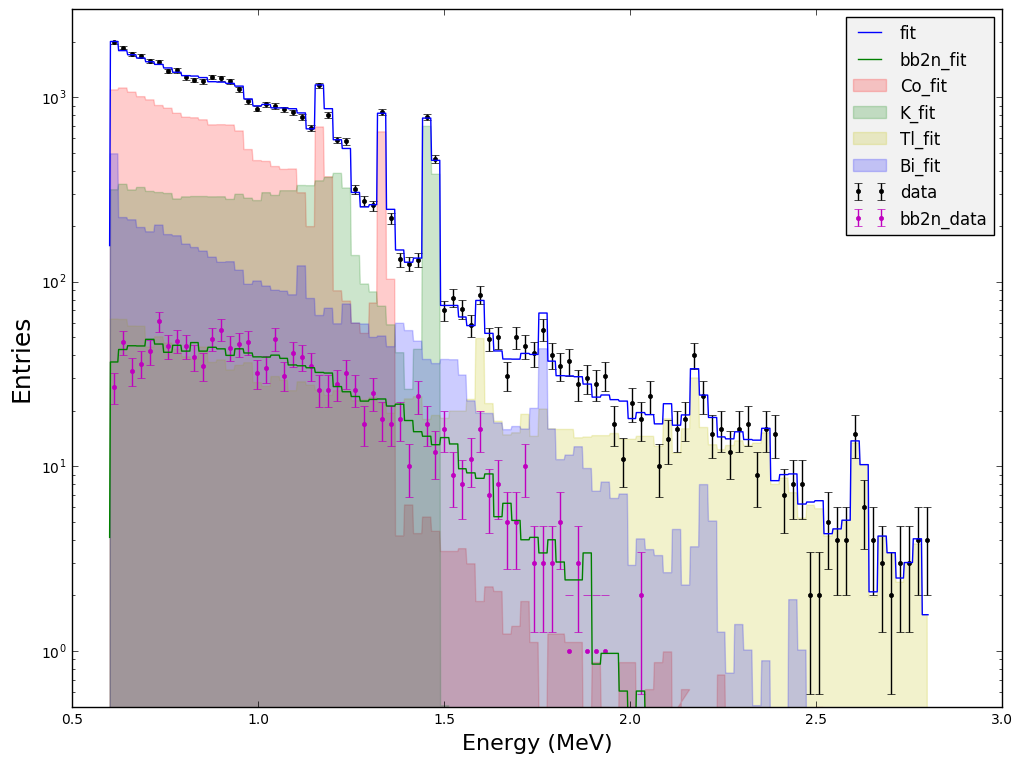

In [53]:
alfa= 0.2
plt.semilogy()
plt.ylim(0.5,3e3)
plt.errorbar(Ea,totala,yerr=np.sqrt(totala),marker='.',elinewidth=1,
             linewidth=0,label='data',color='black')
plt.errorbar(Ea,testnna,yerr=np.sqrt(testnna),marker='.',elinewidth=1,
             linewidth=0,label='bb2n_data',color='m')
plt.plot(Ep,fittotal,label='fit')
plt.plot(Ep,y_bb2nP,label='bb2n_fit')
plt.fill_between(Ep,0,y_CoP,label='Co_fit',alpha=alfa,color='r')
plt.fill_between(Ep,0,y_KP,label='K_fit',alpha=alfa,color='g')
plt.fill_between(Ep,0,y_TlP,label='Tl_fit',alpha=alfa,color='y')
plt.fill_between(Ep,0,y_BiP,label='Bi_fit',alpha=alfa,color='b')
#plt.plot(E)

plt.gcf().set_size_inches(12,9)
plt.legend().get_frame().set_facecolor('0.95')
plt.xlabel('Energy (MeV)',fontsize=16)
plt.ylabel('Entries',fontsize=18)
plt.savefig('fitspectrum.pdf')

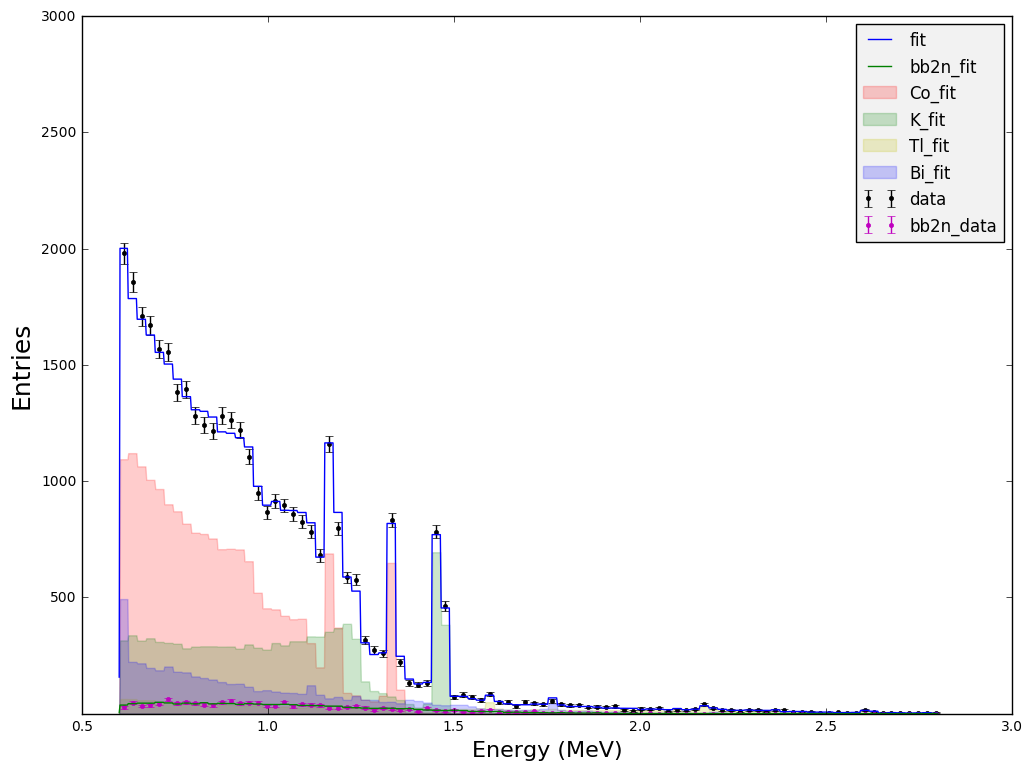

In [54]:
alfa= 0.2
#plt.semilogy()
plt.ylim(0.5,3e3)
plt.errorbar(Ea,totala,yerr=np.sqrt(totala),marker='.',elinewidth=1,
             linewidth=0,label='data',color='black')
plt.errorbar(Ea,testnna,yerr=np.sqrt(testnna),marker='.',elinewidth=1,
             linewidth=0,label='bb2n_data',color='m')
plt.plot(Ep,fittotal,label='fit')
plt.plot(Ep,y_bb2nP,label='bb2n_fit')
plt.fill_between(Ep,0,y_CoP,label='Co_fit',alpha=alfa,color='r')
plt.fill_between(Ep,0,y_KP,label='K_fit',alpha=alfa,color='g')
plt.fill_between(Ep,0,y_TlP,label='Tl_fit',alpha=alfa,color='y')
plt.fill_between(Ep,0,y_BiP,label='Bi_fit',alpha=alfa,color='b')
#plt.plot(E)
plt.gcf().set_size_inches(12,9)
plt.legend().get_frame().set_facecolor('0.95')
plt.xlabel('Energy (MeV)',fontsize=16)
plt.ylabel('Entries',fontsize=18)
plt.savefig('fitspectrum.pdf')

In [55]:
total.sum()

36653.0

In [56]:
result.sum()

36652.896547500008